# 『Kickstarter Projects』
## 課題 クラウドファンデイングが成功するか(state)を予測
### 名前 北神眞哉

### 目次  
1. データ概要
1. 前処理
1. モデル生成
1. モデルの評価結果

## 1.データ概要

In [2]:
%matplotlib inline
import codecs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.linear_model import SGDClassifier
from sklearn import linear_model
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv ('./kickstarter-projects/ks-projects-201801.csv')

In [5]:
display(df.head())
df.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


### データ

 - ID ... 内部ID
 - name ... プロジェクト名　
 - categroy ... カテゴリー   
 - main_category ... 主カテゴリー 
 - currensy ... 通貨の種類  
 - deadlile ... 期日             
 - goal ... 目標金額 
 - launched ... プロジェクト開始日
 - pledged ... 集金額 
 - state ... プロジェクトの現状 
 - backers ... 支援者数 
 - country ... 発案元の国 
 - usd pledged ... USD換算の集金額(KS)
 - usd_pledged_real ...　USD換算の集金額(fixer)
 - usd_goal_real ... USD換算の目標金額 


- 目的変数
　- state
 
- 説明変数
  - カテゴリー 
     - categroy
     - main_category
     - currensy
     - country
  - 数値系 
     - deadline - launched
     - backers
     - usd_goal_real
  
- 削るもの
  - ID
  - name
  - goal
  - pledged
  - usd pledged
  - usd_pledged_real

カテゴリー 159


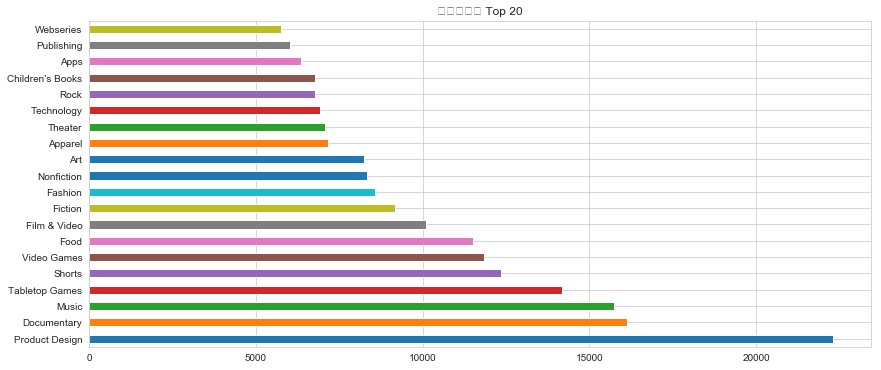

In [6]:
print('カテゴリー', df['category'].nunique())
df['category'].value_counts()[:20].plot(kind='barh',
                                       figsize=(14,6),
                                       title='カテゴリー Top 20')

メインカテゴリー 15


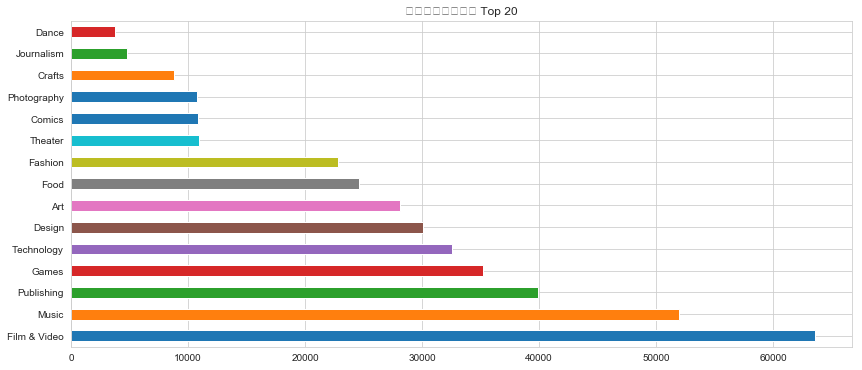

In [7]:
print('メインカテゴリー', df['main_category'].nunique())
df['main_category'].value_counts()[:20].plot(kind='barh',
                                       figsize=(14,6),
                                       title='メインカテゴリー Top 20')

国名 23


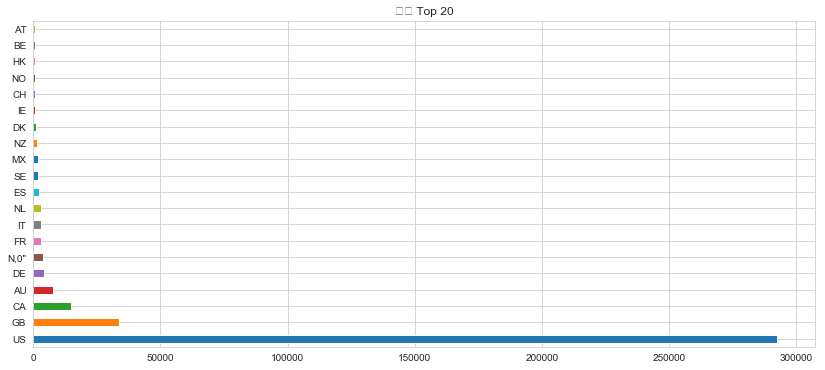

In [8]:
print('国名', df['country'].nunique())
df['country'].value_counts()[:20].plot(kind='barh',
                                       figsize=(14,6),
                                       title='国名 Top 20')        

通貨 14


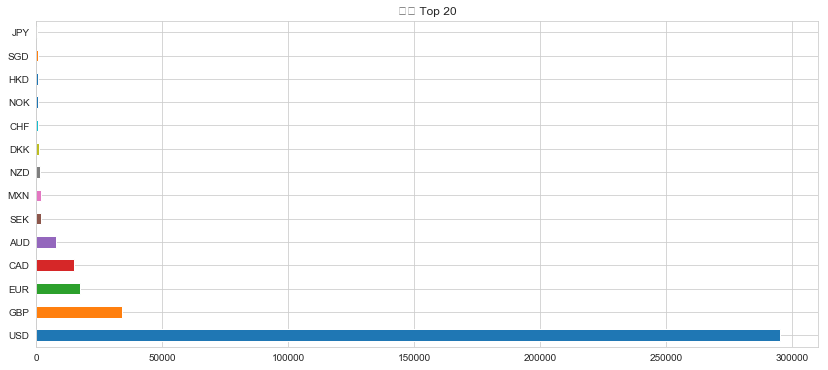

In [9]:
print('通貨', df['currency'].nunique())
df['currency'].value_counts()[:20].plot(kind='barh',
                                       figsize=(14,6),
                                       title='通貨 Top 20')

#### 支援者数

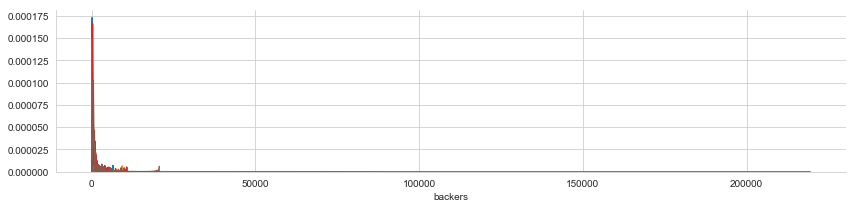

In [10]:
fig = sns.FacetGrid(data=df, hue='state', aspect=4)
fig.map(sns.kdeplot, 'backers', shade=True)

#### USD換算の目標金額

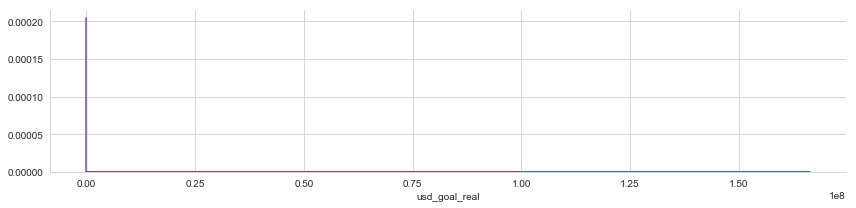

In [11]:
fig = sns.FacetGrid(data=df, hue='state', aspect=4)
fig.map(sns.kdeplot, 'usd_goal_real', shade=True)

## 2.前処理

In [12]:
df = df.drop('ID', axis = 1)
df = df.drop('name', axis= 1)
df = df.drop('goal', axis = 1)
df = df.drop('pledged', axis = 1)
df = df.drop('usd pledged', axis = 1)
df = df.drop('usd_pledged_real', axis = 1)

In [13]:
print(df['state'].value_counts(dropna=False))

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


In [14]:
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')].copy()

In [15]:
df['state'] = df['state'].map({'successful': 1, 'failed': 0})

In [16]:
print(df['state'].value_counts(dropna=False))

0    197719
1    133956
Name: state, dtype: int64


In [17]:
df['launched'] = pd.to_datetime(df['launched'])
df['deadline'] = pd.to_datetime(df['deadline'])

df['duration_days'] = df['deadline'].subtract(df['launched']).astype('timedelta64[D]')

df.drop(['launched', 'deadline'], axis=1,inplace=True)

In [18]:
df.head(5)

,category,main_category,currency,state,backers,country,usd_goal_real,duration_days
0,Poetry,Publishing,GBP,0,0,GB,1533.95,58.0
1,Narrative Film,Film & Video,USD,0,15,US,30000.00,59.0
2,Narrative Film,Film & Video,USD,0,3,US,45000.00,44.0
3,Music,Music,USD,0,1,US,5000.00,29.0
5,Restaurants,Food,USD,1,224,US,50000.00,34.0


In [19]:
dummy_df = pd.get_dummies(df, columns=['category','main_category','currency','country'],drop_first=True)

In [20]:
dummy_df.head()

,state,backers,usd_goal_real,duration_days,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,0,1533.95,58.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,15,30000.00,59.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,3,45000.00,44.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,5000.00,29.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,224,50000.00,34.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 3.モデル生成

In [21]:
y = dummy_df['state']

In [22]:
X = dummy_df.drop('state', axis=1)

In [23]:
from sklearn.preprocessing import StandardScaler
# Goal、Dulation_daysを標準化する
norm_X = X
stdsc = StandardScaler()
norm_X['backers_std'] =  stdsc.fit_transform(norm_X[['backers']].values)
norm_X['usd_goal_real_std'] =  stdsc.fit_transform(norm_X[['usd_goal_real']].values)
norm_X['duration_days_std'] =  stdsc.fit_transform(norm_X[['duration_days']].values)
norm_X = norm_X.drop(['backers','usd_goal_real','duration_days'],axis=1)
X = norm_X

In [24]:
X.head()

,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,...,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,backers_std,usd_goal_real_std,duration_days_std
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.120549,-0.036049,1.969990
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,-0.105012,-0.010379,2.048648
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,-0.117442,0.003147,0.868782
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,-0.119514,-0.032924,-0.311084
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.111472,0.007656,0.082205


In [25]:
X.describe()

,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,...,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,backers_std,usd_goal_real_std,duration_days_std
count,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,...,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,3.316750e+05,3.316750e+05,3.316750e+05
mean,0.002343,0.008261,0.001872,0.000690,0.006672,0.002222,0.018590,0.015940,0.001936,0.022570,...,0.000633,0.007269,0.001755,0.003841,0.004550,0.001369,0.788000,-1.217544e-16,4.508065e-16,-2.622543e-15
std,0.048344,0.090515,0.043230,0.026267,0.081411,0.047086,0.135074,0.125245,0.043953,0.148529,...,0.025155,0.084949,0.041853,0.061858,0.067297,0.036972,0.408725,1.000002e+00,1.000002e+00,1.000002e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.205495e-01,-3.743254e-02,-2.592157e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.184779e-01,-3.562901e-02,-3.110835e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.050123e-01,-3.292369e-02,-3.110835e-01
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-5.529330e-02,-2.390597e-02,1.608628e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.271180e+02,1.499826e+02,4.565695e+00


In [26]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=1000, fit_intercept=True, random_state=1234)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

In [28]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 88.702%
適合率（Precision） = 87.242%
再現率（Recall） = 94.930%
F1値（F1-score） = 90.924%


In [29]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = Failed', '正解 = Success'], 
                        columns=['予測 = Failed', '予測 = Success'])
conf_mat

,予測 = Failed,予測 = Success
正解 = Failed,187695,10024
正解 = Success,27448,106508


ホールドアウト法

In [30]:
from sklearn.model_selection import train_test_split
## 9:1にトレーニングとテストデータを分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.2,
#    random_state=42
)
 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)    

(265340, 210) (265340,)
(66335, 210) (66335,)


In [31]:
# SGDの実行

clf_sgd = SGDClassifier(loss='log', penalty='none', fit_intercept=True, random_state=1234)
clf_sgd.fit(X_train, y_train)

acc_log = round(clf_sgd.score(X_test, y_test) * 100, 2)
print('SGD正答率={:.3f}%'.format(acc_log))

SGD正答率=88.410%


In [32]:
#clf_sgd = SGDClassifier(loss='log', penalty='l2', fit_intercept=True, random_state=1234)
#clf_sgd.fit(X_train, y_train)

#acc_log = round(clf_sgd.score(X_test, y_test) * 100, 2)
#print('SGD正答率={:.3f}%'.format(acc_log))

In [33]:
# ラベルを予測
y_pred = clf.predict(X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 88.661%
適合率（Precision） = 87.191%
再現率（Recall） = 94.967%
F1値（F1-score） = 90.913%


In [34]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = Failed', '正解 = Success'], 
                        columns=['予測 = Failed', '予測 = Success'])
conf_mat

,予測 = Failed,予測 = Success
正解 = Failed,37628,1994
正解 = Success,5528,21185


In [35]:
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数

In [54]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx] #学習用データ
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]    #テスト用データ
    
    # 学習用データを使ってSGDモデルを学習
    clf_sgd2 = SGDClassifier(loss='log', penalty='l2', fit_intercept=True, random_state=1234)
    clf_sgd2.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = clf_sgd2.predict(X_test)
    
    # テストデータに対するMAEを計算
  #  mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print('SGD正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))
  #  print("MAE = %s"%round(mae, 3))
    print()
    
   # cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
#final_mae = cross_valid_mae / n_split
#print("Cross Validation MAE = %s"%round(final_mae, 3))

#y_pred_test = clf.predict(X_test)
#print("正解率 = {:.3f}%".format(100 * accuracy_score(y_test, y_pred_test)))

Fold 1
SGD正答率 = 83.490%

Fold 2
SGD正答率 = 83.399%

Fold 3
SGD正答率 = 83.773%

Fold 4
SGD正答率 = 83.627%

Fold 5
SGD正答率 = 83.629%

